In [1]:
!pip install tfcausalimpact

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 91.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.0 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_versio

In [2]:
!pip install yfinance

In [4]:
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [6]:
start = "2015-12-28"
training_end = "2018-03-05"
treatment_start = "2018-03-12"
treatment_end = "2018-07-16"
end_stock = "2018-07-17"

In [7]:
# set the timezone to Central Europe Berlin (for cambridge analytical)
import os
os.environ['TZ'] = 'Europe/Berlin'

In [8]:
y = ["META"]
y = yf.download(y,
                start=start,
                end=end_stock,
                interval = "1d")
y = y['Close']

/tmp/ipython-input-683323664.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  y = yf.download(y,
[*********************100%***********************]  1 of 1 completed


In [9]:

y.columns = ['y']
y.head(610)

,y
Date,
2015-12-28,105.352036
2015-12-29,106.674767
2015-12-30,105.640457
2015-12-31,104.088966
2016-01-04,101.662277
...,...
2018-05-23,185.880249
2018-05-24,184.915543
2018-05-25,183.911026


In [10]:
# retrieve financial data for control group - better exclude tech
stocks = ['WMT','DIS','COF','NVS','GOOG','GS','GE','MCD']
X = yf.download(
    tickers = stocks,
    start = start,
    end = end_stock,
    interval = "1d"
)
X.head()



/tmp/ipython-input-1113180739.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  X = yf.download(
[*********************100%***********************]  8 of 8 completed


Price           Close                                                \
Ticker            COF        DIS          GE       GOOG          GS   
Date                                                                  
2015-12-28  61.283382  99.525108  131.167038  37.866371  148.747513   
2015-12-29  61.819538  99.367386  132.780121  38.566078  150.311798   
2015-12-30  61.333633  98.680664  131.803772  38.287983  149.066925   
2015-12-31  60.470734  97.511429  132.228271  37.686104  147.609070   
2016-01-04  59.264294  95.562691  130.360489  36.839890  145.078323   

Price                                             High              ...  \
Ticker            MCD        NVS        WMT        COF         DIS  ...   
Date                                                                ...   
2015-12-28  93.646500  53.479591  16.912058  61.509579  100.406680  ...   
2015-12-29  94.687454  54.281021  17.151472  61.987091  100.258239  ...   
2015-12-30  94.182747  53.960449  17.170952  61.827925   99.488003  ...   
2015-12-31  93.165451  53.041889  17.065170  61.375534   98.652832  ...   
2016-01-04  92.723846  52.863117  17.109713  59.406720   95.980276  ...   

Price            Open              Volume                                \
Ticker            NVS        WMT      COF       DIS        GE      GOOG   
Date                                                                      
2015-12-28  53.793999  16.864731  1569800   9092700   5541585  30306000   
2015-12-29  54.170053  16.981654  1506200   8607200   6969397  35300000   
2015-12-30  54.533777  17.165384  1414600   4917000   6077847  25866000   
2015-12-31  53.282318  17.073522  1722100   6670100  10914634  30018000   
2016-01-04  52.764479  16.842461  3636200  12531500  13120985  65456000   

Price                                            
Ticker           GS      MCD      NVS       WMT  
Date                                             
2015-12-28  1723300  2777200  1920636  16265100  
2015-12-29  1848900  3213900  2044066  23650800  
2015-12-30  1514300  2400800  1769976  17150100  
2015-12-31  1773900  3723200  1162760  19725300  
2016-01-04  3745500  9995000  2550841  35967600  

[5 rows x 40 columns]

Data Processing

In [11]:
X = X['Close']
X.head()

Ticker,COF,DIS,GE,GOOG,GS,MCD,NVS,WMT
Date,,,,,,,,
2015-12-28,61.283382,99.525108,131.167038,37.866371,148.747513,93.646500,53.479591,16.912058
2015-12-29,61.819538,99.367386,132.780121,38.566078,150.311798,94.687454,54.281021,17.151472
2015-12-30,61.333633,98.680664,131.803772,38.287983,149.066925,94.182747,53.960449,17.170952
2015-12-31,60.470734,97.511429,132.228271,37.686104,147.609070,93.165451,53.041889,17.065170
2016-01-04,59.264294,95.562691,130.360489,36.839890,145.078323,92.723846,52.863117,17.109713


In [12]:
df = pd.concat([y, X], axis = 1).dropna()
df.head()

,y,COF,DIS,GE,GOOG,GS,MCD,NVS,WMT
Date,,,,,,,,,
2015-12-28,105.352036,61.283382,99.525108,131.167038,37.866371,148.747513,93.646500,53.479591,16.912058
2015-12-29,106.674767,61.819538,99.367386,132.780121,38.566078,150.311798,94.687454,54.281021,17.151472
2015-12-30,105.640457,61.333633,98.680664,131.803772,38.287983,149.066925,94.182747,53.960449,17.170952
2015-12-31,104.088966,60.470734,97.511429,132.228271,37.686104,147.609070,93.165451,53.041889,17.065170
2016-01-04,101.662277,59.264294,95.562691,130.360489,36.839890,145.078323,92.723846,52.863117,17.109713


In [14]:
# analysis for stationarity
# prepare a df with only training data
df_train = df[start:treatment_start]
df_train.head()

,y,COF,DIS,GE,GOOG,GS,MCD,NVS,WMT
Date,,,,,,,,,
2015-12-28,105.352036,61.283382,99.525108,131.167038,37.866371,148.747513,93.646500,53.479591,16.912058
2015-12-29,106.674767,61.819538,99.367386,132.780121,38.566078,150.311798,94.687454,54.281021,17.151472
2015-12-30,105.640457,61.333633,98.680664,131.803772,38.287983,149.066925,94.182747,53.960449,17.170952
2015-12-31,104.088966,60.470734,97.511429,132.228271,37.686104,147.609070,93.165451,53.041889,17.065170
2016-01-04,101.662277,59.264294,95.562691,130.360489,36.839890,145.078323,92.723846,52.863117,17.109713


In [15]:
# stationarity test
from statsmodels.tsa.stattools import adfuller
# H0 of AD fuller test is that time series is not stationary
result = adfuller(df_train['y'])[1] # pvalue
# augmented dickey-fuller unit root test can be used to test for a unit root in a univariate process in the presence of serial correlation
if result< 0.05:
  print("The TS is stationary")
else:
  print("The Time Series is not stationary")

The Time Series is not stationary


In [16]:
# Differencing
differencing = df_train.pct_change().dropna()

In [17]:
adfuller(differencing['y'])[1]

6.160179499610406e-17

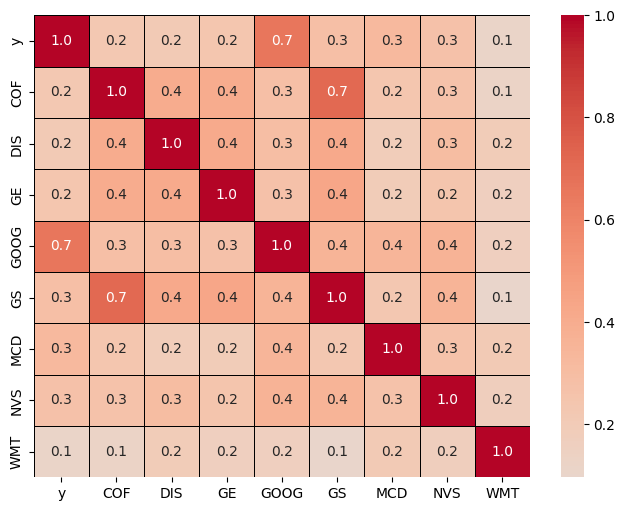

In [18]:
# Data Analysis - Correlation matrix
# heatmap to analyze the correlations
plt.figure(figsize=(8,6))
sns.heatmap(
    differencing.corr(numeric_only=True),
    annot = True,
    cmap = 'coolwarm',
    center = 0,
    linewidth = 0.5,
    linecolor = 'black',
    fmt = '.1f')
plt.show() # low correlations

In [19]:
# remove WMT
df = df.drop(columns=['WMT'])

In [20]:
df.head(610)

,y,COF,DIS,GE,GOOG,GS,MCD,NVS
Date,,,,,,,,
2015-12-28,105.352036,61.283382,99.525108,131.167038,37.866371,148.747513,93.646500,53.479591
2015-12-29,106.674767,61.819538,99.367386,132.780121,38.566078,150.311798,94.687454,54.281021
2015-12-30,105.640457,61.333633,98.680664,131.803772,38.287983,149.066925,94.182747,53.960449
2015-12-31,104.088966,60.470734,97.511429,132.228271,37.686104,147.609070,93.165451,53.041889
2016-01-04,101.662277,59.264294,95.562691,130.360489,36.839890,145.078323,92.723846,52.863117
...,...,...,...,...,...,...,...,...
2018-05-23,185.880249,84.351776,98.420288,64.699287,53.617580,200.848541,135.620575,52.593140
2018-05-24,184.915543,84.052017,97.674179,66.615654,53.595234,199.404312,136.266724,52.414223
2018-05-25,183.911026,83.593536,97.760262,66.752525,53.417454,198.483688,136.954803,52.366062


Google causal impact

In [21]:
pre_period = [start, training_end]
# pre_period = [start, treatment_start]
post_period = [treatment_start, treatment_end]


In [22]:
%%time
# build the google causal impact model
impact = CausalImpact(
    data = df,
    pre_period = pre_period,
    post_period = post_period,

)

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


CPU times: user 2min 40s, sys: 6.51 s, total: 2min 46s
Wall time: 1min 54s


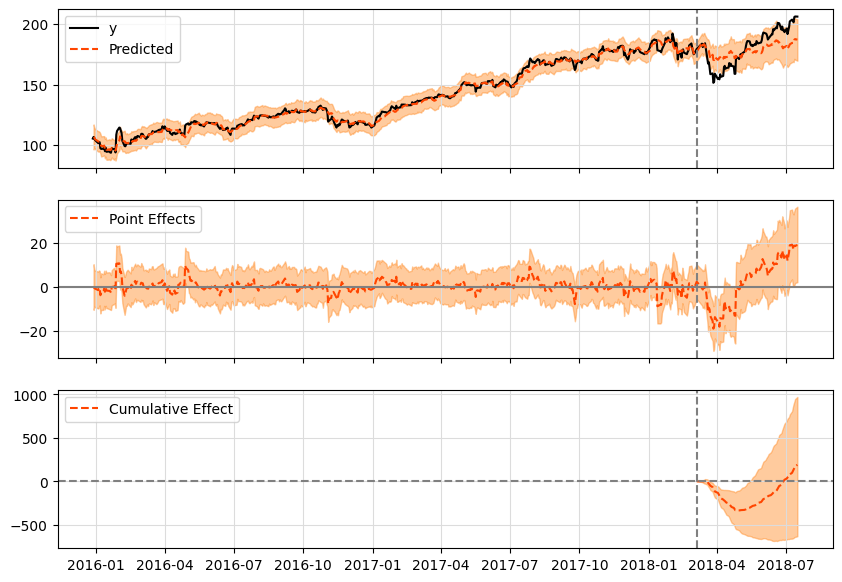

In [23]:
# Visualize the output
impact.plot()

In [25]:
# preview the results
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    180.47             15881.29
Prediction (s.d.)         178.31 (4.75)      15691.61 (417.79)
95% CI                    [168.58, 187.19]   [14835.1, 16472.82]

Absolute effect (s.d.)    2.16 (4.75)        189.68 (417.79)
95% CI                    [-6.72, 11.89]     [-591.52, 1046.19]

Relative effect (s.d.)    1.21% (2.66%)      1.21% (2.66%)
95% CI                    [-3.77%, 6.67%]    [-3.77%, 6.67%]

Posterior tail-area probability p: 0.31
Posterior prob. of a causal effect: 69.03%

For more details run the command: print(impact.summary('report'))


In [26]:
# 69% that there is an impact
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 180.47. In the absence of an
intervention, we would have expected an average response of 178.31.
The 95% interval of this counterfactual prediction is [168.58, 187.19].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 2.16 with a 95% interval of
[-6.72, 11.89]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 15881.29.
Had the intervention not taken place, we would have expected
a sum of 15691.61. The 95% interval of this prediction is [14835.1, 16472.82].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an inc